 **Elections 2008**
 ***

# Table of Contents
 <p><div class="lev1"><a href="#Data-Preparation"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></div><div class="lev2"><a href="#Load-data"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load data</a></div><div class="lev2"><a href="#Delete-unwanted-columns-and-encode-categorical-variables-as-numbers"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Delete unwanted columns and encode categorical variables as numbers</a></div><div class="lev2"><a href="#Impute-all-missing-values-with-only-one-line-of-code"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Impute all missing values with only one line of code</a></div><div class="lev2"><a href="#Select-Training-set-and-calculate-target-variable"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Select Training set and calculate target variable</a></div><div class="lev2"><a href="#Remove-unwanted-columns-from-training-set.--Do-the-same-with-testing-set"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Remove unwanted columns from training set.  Do the same with testing set</a></div><div class="lev2"><a href="#Split-Training-data-to-two-sets:-one-that-we-will-use-for-training-and-another-for-validation"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Split Training data to two sets: one that we will use for training and another for validation</a></div><div class="lev1"><a href="#Modeling"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></div><div class="lev2"><a href="#Regression-Trees"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Regression Trees</a></div><div class="lev3"><a href="#Train-and-visualize-a-Tree."><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Train and visualize a Tree.</a></div><div class="lev3"><a href="#See-how-tree-depth-influences-accuracy-of-the-model-on-training-and-validation-sets"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>See how tree depth influences accuracy of the model on training and validation sets</a></div><div class="lev2"><a href="#Lasso-Regression"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Lasso Regression</a></div>

* Install git from here https://git-scm.com/book/en/v2/Getting-Started-Installing-Git
* Install graphviz from here http://www.graphviz.org/Download..php

Now you can install packages from Jupyter nootbook 

In [ ]:
%%bash
# bash magic allows to run code in the shell/command line
pip install seaborn
#Pydot package on pip is not Python3 frienly, so it is better to intall it from developer repository
git clone https://github.com/nlhepler/pydot.git
cd pydot
python setup.py install

In [1]:
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import os
os.chdir('/media/andrey/Docs/DS_class')
from sklearn.preprocessing import LabelEncoder,Imputer
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor,export_graphviz
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from ipywidgets import *
from io import StringIO
import pydot# doesn't come with anaconda
from sklearn.linear_model import Lasso
from wordcloud import WordCloud #doesn't come with anaconda
import seaborn as sns #doesn't come with anaconda

# Data Preparation

## Load data

In [2]:
dataDf=pd.read_csv('Obama.csv',na_values='NaN')
print ('Data frame shape: '+ 'number of rows-'+str(dataDf.shape[0])+', '+'number of cols-'+str(dataDf.shape[1]))
dataDf.head(2)

Data frame shape: number of rows-2868, number of cols-41


,County,State,Region,FIPS,ElectionDate,ElectionType,TotalVote,Clinton,Obama,MalesPer100Females,...,SocialSecurityRate,RetiredWorkers,Disabilities,DisabilitiesRate,Homeowner,SameHouse1995and2000,Pop,PopDensity,LandArea,FarmArea
0,Adair,IA,Midwest,19001,1/3/2008,Caucuses,75.0,22.0,24.0,96.7,...,23222.0,1230.0,90.0,1145.0,75.0,66.0,7714,13.5,570.0,373.0
1,Adams,IA,Midwest,19003,1/3/2008,Caucuses,50.0,18.0,7.0,96.8,...,26032.0,720.0,78.0,1829.0,74.7,65.4,4192,9.9,425.0,238.0


## Delete unwanted columns and encode categorical variables as numbers

In [3]:
dataDf.drop(['ElectionDate','FIPS'], axis=1, inplace=True)
for column in 'County,State,Region,ElectionType'.split(','):
    globals()['encoder_'+column]=LabelEncoder()
    dataDf[column]=globals()['encoder_'+column].fit_transform(dataDf[column])
dataDf.head(2)

,County,State,Region,ElectionType,TotalVote,Clinton,Obama,MalesPer100Females,AgeBelow35,Age35to65,...,SocialSecurityRate,RetiredWorkers,Disabilities,DisabilitiesRate,Homeowner,SameHouse1995and2000,Pop,PopDensity,LandArea,FarmArea
0,4,10,0,0,75.0,22.0,24.0,96.7,37.7,40.3,...,23222.0,1230.0,90.0,1145.0,75.0,66.0,7714,13.5,570.0,373.0
1,5,10,0,0,50.0,18.0,7.0,96.8,37.1,40.8,...,26032.0,720.0,78.0,1829.0,74.7,65.4,4192,9.9,425.0,238.0


Since we created separate encoders for each variable we always can decode numbers back to categorical variables. For example 'ElectionType'

In [4]:
encoder_ElectionType.inverse_transform(dataDf['ElectionType'])

array(['Caucuses', 'Caucuses', 'Caucuses', ..., 'Primary', 'Primary',
       'Primary'], dtype=object)

## Impute all missing values with only one line of code

In [5]:
meanImputer=Imputer(strategy='mean')
print ('Number of missings in column "Black" before imputing:')
print (len(dataDf[dataDf['Black'].isnull()]))
dataDf.iloc[:,9:]=meanImputer.fit_transform(dataDf.iloc[:,9:])
print()
print ('Number of missings in column "Black" after imputing:')
print (len(dataDf[dataDf['Black'].isnull()]))

Number of missings in column "Black" before imputing:
80

Number of missings in column "Black" after imputing:
0


## Select Training set and calculate target variable

In [6]:
TrainDf=dataDf[~dataDf.Obama.isnull()]
TrainDf['Target']=(TrainDf.Obama - TrainDf.Clinton) / TrainDf.TotalVote
print ('Check that our calculations are correct:')
TrainDf[['Obama','Clinton','TotalVote','Target']].head(3)

Check that our calculations are correct:


,Obama,Clinton,TotalVote,Target
0,24.0,22.0,75.0,0.026667
1,7.0,18.0,50.0,-0.220000
2,33.0,25.0,80.0,0.100000


## Remove unwanted columns from training set.  Do the same with testing set

In [7]:
TrainDf.drop(['Obama','Clinton','TotalVote'], axis=1, inplace=True)
print ('Traing set: '+ 'number of rows-'+str(TrainDf.shape[0])+', '+'number of cols-'+str(TrainDf.shape[1]))
print (TrainDf.head(2).iloc[:,:6])#need to cut nomber of columns just to make it look nicer
print ()
TestDf=dataDf[dataDf.Obama.isnull()].drop(['Obama','Clinton','TotalVote'], axis=1)
print ('Testing set: '+ 'number of rows-'+str(TestDf.shape[0])+', '+'number of cols-'+str(TestDf.shape[1]))
print (TestDf.head(2).iloc[:,:6])

Traing set: number of rows-1737, number of cols-37
   County  State  Region  ElectionType  MalesPer100Females  AgeBelow35
0       4     10       0             0                96.7        37.7
1       5     10       0             0                96.8        37.1

Testing set: number of rows-1131, number of cols-36
      County  State  Region  ElectionType  MalesPer100Females  AgeBelow35
1737     680      9       3             0               100.0        46.9
1738     712      9       3             0                99.1        46.0


## Split Training data to two sets: one that we will use for training and another for validation

In [8]:
X_train, X_valid, y_train, y_valid=train_test_split(TrainDf.drop('Target', axis=1), 
                                                    TrainDf.Target, train_size=0.75,random_state=123 )
print ('X_train shape: '+ 'number of rows-'+str(X_train.shape[0])+', '+'number of cols-'+str(X_train.shape[1])) 
print () 
print ('X_valid shape: '+ 'number of rows-'+str(X_valid.shape[0])+', '+'number of cols-'+str(X_valid.shape[1]))

X_train shape: number of rows-1302, number of cols-36

X_valid shape: number of rows-435, number of cols-36


# Modeling

## Regression Trees

### Train and visualize a Tree.

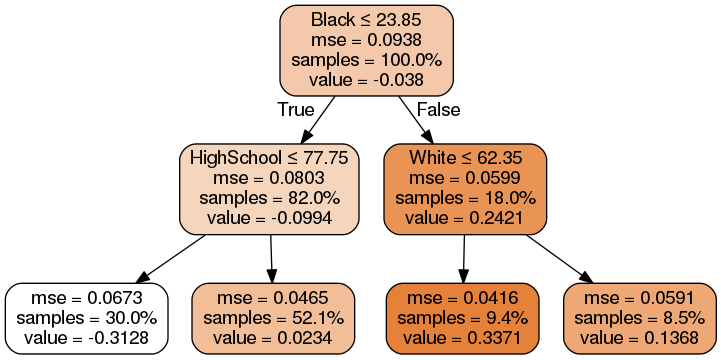

In [9]:
from IPython.display import Image
Depth=2  
tree=DecisionTreeRegressor( max_depth=Depth, random_state=123)
model=tree.fit(X_train,y_train)
# when tree has more than 3 levels it is difficult to read, so you need to rotate it for deeper threes.
if Depth<=3: rotation=0    
else: rotation=1
dot_data = StringIO()
export_graphviz(model, out_file=dot_data, feature_names=X_train.columns,rounded=True,  
                         special_characters=True,proportion=True,rotate=rotation,filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### See how tree depth influences accuracy of the model on training and validation sets

<function __main__.graphs>

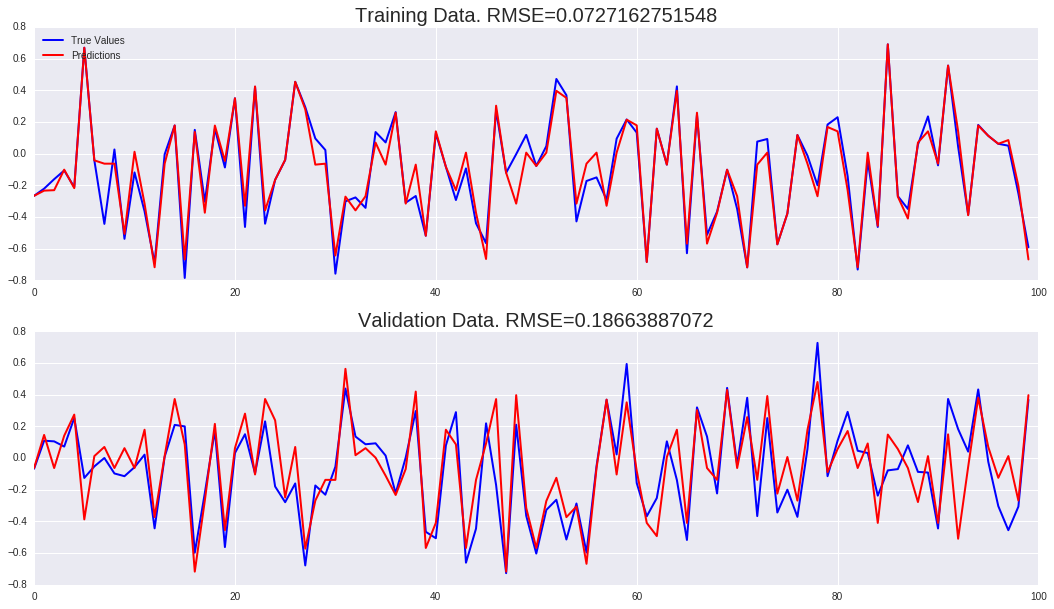

In [10]:
def graphs(Depth):
    pointToShow=100
    tree=DecisionTreeRegressor( max_depth=Depth, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=123, max_leaf_nodes=None)

    model=tree.fit(X_train,y_train)
    predVal=model.predict(X_valid)
    predTrain=model.predict(X_train)
    errorVal=MSE(predVal,y_valid)**0.5
    errorTrain=MSE(predTrain,y_train)**0.5
    
    
    axisX=range(pointToShow)
    f, axes = plt.subplots(2, 1, figsize=(18, 10), sharey=True)

    axes[0].plot( axisX,y_train[:pointToShow],color='b',lw=2)
    axes[0].plot( axisX,predTrain[:pointToShow],color='r',lw=2)
    axes[0].set_title("Training Data. RMSE="+str(errorTrain) ,size=20)

    axes[1].plot( axisX,y_valid[:pointToShow],color='b',lw=2)
    axes[1].plot( axisX,predVal[:pointToShow],color='r',lw=2)
    axes[1].set_title("Validation Data. RMSE=" + str(errorVal),size=20)
    axes[0].legend(['True Values', 'Predictions'], loc='upper left')
interact(graphs,Depth=[1,20])

## Lasso Regression

In [11]:
X_train.drop(['County', 'State','Region'], axis=1, inplace=True)
X_valid.drop(['County', 'State','Region'], axis=1, inplace=True)

<function __main__.ImpFeatures>

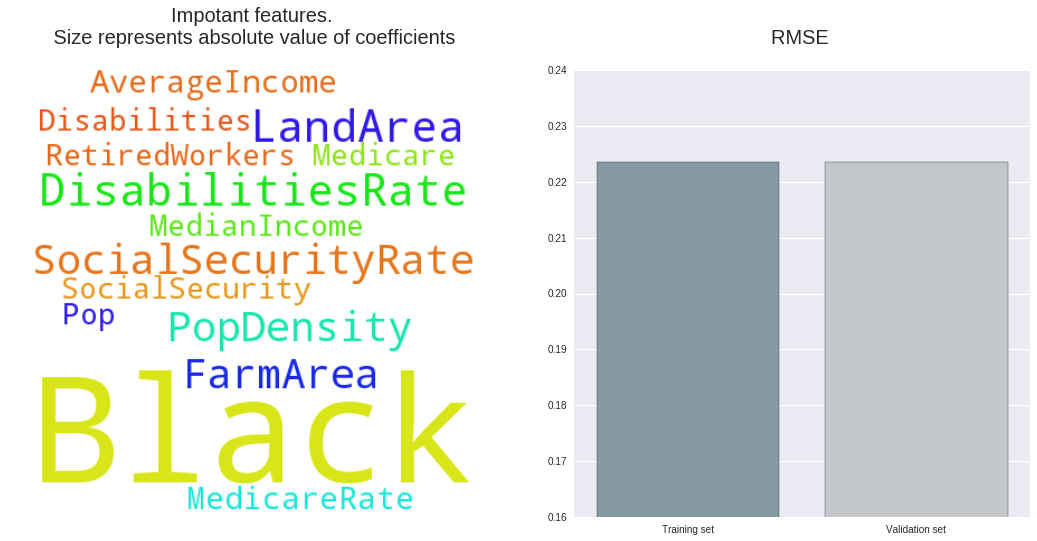

In [12]:
def ImpFeatures(alpha):    
    lasso= Lasso(alpha=alpha,selection='cyclic',max_iter=100000,positive=False)
    lasso.fit(X_train,y_train)
    
    predVal=lasso.predict(X_valid)
    predTrain=lasso.predict(X_train)
    errorVal=MSE(predVal,y_valid)**0.5
    errorTrain=MSE(predTrain,y_train)**0.5     
    
    cloud=pd.DataFrame()
    cloud['features']=X_train.columns
    cloud['scores']=lasso.coef_*100000
    cloud['scores']=cloud['scores'].apply(lambda x: np.absolute(x))
    cloud=cloud[cloud.scores!=0]
    tuples = [tuple(x) for x in cloud.values]
    wordcloud = WordCloud(background_color='white',height=400).generate_from_frequencies(tuples)
    
    f, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=False)
    axes[0].imshow(wordcloud)
    axes[0].axis("off") 
    axes[0].set_title("Impotant features. \n Size represents absolute value of coefficients \n",size=20)

    sns.set_style("white")
    sns.set(font_scale=2)
    sns.barplot(x=['Training set', 'Validation set'], y=[errorTrain,errorTrain],
                ci='None',palette="RdBu_d", ax=axes[1])
    axes[1].set_ylim([0.16, 0.24])
    axes[1].set_title("RMSE \n",size=20)
interact(ImpFeatures,alpha=[0.0001,0.99])